##### Introdução

Com a baseline previamente estabelecida, este trecho tem como objetivo utilizá-la como referência central para a realização de comparações e validações dos resultados obtidos ao longo do desenvolvimento. A partir dessa linha de base, será possível mensurar de forma objetiva o impacto de diferentes configurações e abordagens no desempenho do sistema, permitindo uma análise criteriosa e fundamentada no contexto da Neuro-Evolução.

**dados**
-   Os dados analisados são referentes às <a href="https://gml.noaa.gov/ccgg/trends/gl_data.html">Tendências do dióxido de carbono atmosférico</a>, cobrindo o período de 1979 à 2024.
-   As medições estão na escala de partes por milhão (ppm). Por exemplo uma concentração de 0,000400 corresponde a 400 ppm.
    -   **Mais especificamente:** a medição representa uma fração molar de CO₂ no ar seco, ou seja, o número de moléculas de dióxido de carbono dividido pelo número total de moléculas no ar (incluindo o próprio CO₂), após a remoção do vapor d’água.

**dataSet**
-   Obtido a partir do site <a href="https://gml.noaa.gov/">gml.noaa.gov</a>, que é um site oficial do governo dos Estados Unidos, cuja sigla GML e NOAA significam respectivamente, Global Monitoring Laboratory (Laboratório de Monitoramento Global) e National Oceanic and Atmospheric Administration (Administração Oceânica e Atmosférica Nacional)

## Importação de bibliotecas

In [375]:
# Bibliotecas principais do TensorFlow e Keras para Deep Learning
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt

# Controle de aleatoriedade e ambiente
import random
import os

# Pré-processamento e divisão de dados
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Métricas de avaliação
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

# Bibliotecas auxiliares
import aux_functions as aux
import importlib
importlib.reload(aux)

<module 'aux_functions' from '/home/elizeta/projects/Iniciação Científica/Otimizacao-de-Gas-com-Neuro-Evolucao/Trends_Atmospheric_CO2/aux_functions.py'>

In [376]:
usar_CPU = True #Deixar True ou False

if usar_CPU:
    tf.config.set_visible_devices([], 'GPU')
    print("Dispositivos visíveis:", tf.config.get_visible_devices())
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

Dispositivos visíveis: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Análise de Séries temporais com Deep Learning Sem Cross-Validation

## Índice
- [x](#x)

In [377]:
# Garantir reprodutibilidade total
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [378]:
full_data_set = aux.ler_csv('dataSet.csv')
series = aux.ler_csv('dataSet.csv', average_only=True)

series

data
1979-01-01    336.56
1979-02-01    337.29
1979-03-01    337.88
1979-04-01    338.32
1979-05-01    338.26
               ...  
2024-08-01    420.19
2024-09-01    420.50
2024-10-01    422.32
2024-11-01    424.07
2024-12-01    425.19
Name: average, Length: 552, dtype: float64

In [379]:
dataset = series.values
dataset = dataset.astype(np.float32)

print(type(dataset))
dataset

<class 'numpy.ndarray'>


array([336.56, 337.29, 337.88, 338.32, 338.26, 337.38, 335.56, 334.36,
       335.02, 336.36, 337.36, 337.89, 338.57, 339.26, 339.59, 339.99,
       340.44, 339.99, 338.44, 337.21, 337.05, 337.82, 338.93, 339.64,
       340.18, 340.75, 341.38, 341.68, 341.43, 340.63, 339.23, 338.08,
       337.97, 339.07, 340.18, 340.75, 341.36, 341.95, 342.23, 342.52,
       342.36, 341.49, 339.75, 338.11, 338.16, 339.62, 340.95, 341.77,
       342.37, 342.74, 343.04, 343.51, 343.84, 343.5 , 342.14, 340.62,
       340.53, 341.75, 342.83, 343.49, 344.32, 344.82, 344.96, 345.19,
       345.33, 344.57, 343.2 , 342.21, 342.13, 342.99, 344.16, 345.  ,
       345.35, 345.8 , 346.64, 346.94, 346.78, 346.26, 344.92, 343.41,
       343.37, 344.64, 345.79, 346.55, 347.11, 347.34, 347.71, 348.22,
       348.32, 347.76, 346.29, 344.92, 344.86, 346.03, 347.3 , 347.76,
       348.02, 348.57, 349.29, 349.98, 350.26, 349.48, 347.86, 346.61,
       346.7 , 347.97, 349.25, 350.21, 350.91, 351.47, 351.85, 352.3 ,
      

In [380]:
window_size = 12
X, y = aux.criarJanelas(dataset, window_size)
X[:3], y[:3]

(array([[336.56, 337.29, 337.88, 338.32, 338.26, 337.38, 335.56, 334.36,
         335.02, 336.36, 337.36, 337.89],
        [337.29, 337.88, 338.32, 338.26, 337.38, 335.56, 334.36, 335.02,
         336.36, 337.36, 337.89, 338.57],
        [337.88, 338.32, 338.26, 337.38, 335.56, 334.36, 335.02, 336.36,
         337.36, 337.89, 338.57, 339.26]], dtype=float32),
 array([338.57, 339.26, 339.59], dtype=float32))

In [381]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size = 0.70, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, shuffle=False)

print(f"DataSet size:   {len(dataset):>8}\n"
      f"Train size:     {len(X_train):>8}\n"
      f"Validation size:{len(X_val):>8}\n"
      f"Test size:      {len(X_test):>8}\n"
      f"Window Size:    {window_size:>8}")
# Pela criação das janelas, o tamanho do dataset não é igual a soma dos tamanhos de treino, validação e teste

DataSet size:        552
Train size:          378
Validation size:      81
Test size:            81
Window Size:          12


In [382]:
scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_val = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)

print(X_scaled_test.shape)
X_scaled_test

(81, 12)


array([[3.0533063, 3.0448413, 2.9822447, 2.856033 , 2.7416558, 2.7342703,
        2.8200102, 2.909019 , 2.9661846, 3.0048237, 3.0369518, 3.05802  ],
       [3.0559661, 2.992355 , 2.8667006, 2.7538474, 2.74762  , 2.8335214,
        2.9217556, 2.9783165, 3.0176253, 3.0509443, 3.0724785, 3.0777273],
       [3.0034423, 2.8767524, 2.7644398, 2.759819 , 2.847029 , 2.9354198,
        2.991126 , 3.0297952, 3.0637908, 3.0865211, 3.0922174, 3.0685303],
       [2.8877563, 2.77444  , 2.770416 , 2.859352 , 2.9490893, 3.0048947,
        3.042659 , 3.0759947, 3.0994022, 3.106288 , 3.0830057, 3.011383 ],
       [2.7853703, 2.780419 , 2.870022 , 2.96154  , 3.0186746, 3.0565052,
        3.0889075, 3.1116323, 3.1191883, 3.097063 , 3.0257661, 2.9082546],
       [2.7913537, 2.8800755, 2.9722846, 3.0312123, 3.070367 , 3.1028233,
        3.1245828, 3.131433 , 3.1099544, 3.039743 , 2.9224713, 2.8176064],
       [2.8910818, 2.98239  , 3.042008 , 3.0829694, 3.1167586, 3.1385522,
        3.1444044, 3.1221924, 3.

In [383]:
def create_model(df_shape, neurons=12, loss='mse', dropout_rate=0, hidden_layers=4):
    model = models.Sequential()
    model.add(Input(shape=(df_shape,)))

    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1))  # Saída

    model.compile(optimizer=Adam(), loss=loss, metrics=['mae'])
    return model

In [384]:
neurons = 16
epochs = 1000
batch_size = 8
hidden_layers = 4

model = create_model(X_scaled_train.shape[1], neurons=neurons, hidden_layers=hidden_layers)

history = model.fit(X_scaled_train,
                    y_train,
                    validation_data=(X_scaled_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

Epoch 1/1000


2025-06-03 12:40:13.736195: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 131568.1250 - mae: 362.4121 - val_loss: 157583.0000 - val_mae: 396.9352
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130481.1172 - mae: 360.9145 - val_loss: 146844.5312 - val_mae: 383.1945
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123971.6562 - mae: 351.7038 - val_loss: 97572.9141 - val_mae: 312.3055
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95502.0703 - mae: 306.2602 - val_loss: 2196.9238 - val_mae: 40.0247
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38716.6602 - mae: 171.1273 - val_loss: 112534.5547 - val_mae: 324.0988
Epoch 6/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27304.3613 - mae: 140.8115 - val_loss: 96251.9531 - val_mae: 299.0370
Epoch 7/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26142.9043 - mae: 137.5527 - val_loss: 95555.3750 - val_mae: 298.1296
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24896.3574 - mae: 134.4637 - val_loss: 

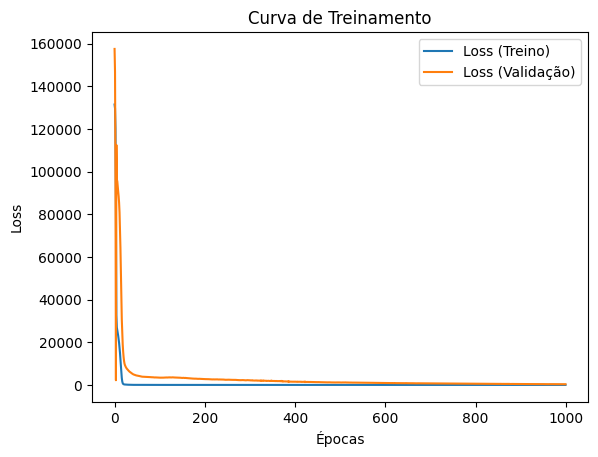

In [385]:
# Histórico de perda (loss)
plt.plot(history.history['loss'], label='Loss (Treino)')
plt.plot(history.history['val_loss'], label='Loss (Validação)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Curva de Treinamento')
plt.show()

In [386]:
y_pred = model.predict(X_scaled_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2025-06-03 12:41:22.768663: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  🔹 R² (Coeficiente de Determinação): ------------ -318.1342
  🔹 RMSE (Raiz Quadrada do Erro Quadrático Médio): 89.8984
  🔹 MAE (Erro Absoluto Médio): ------------------- 85.9093
  🔹 MAPE (Erro Percentual Absoluto): ------------- 20.7133%
  🔹 Acurácia: ------------------------------------ 79.2867%
  🔹 Neurons: ----- 16
  🔹 Epochs: ------ 1000
  🔹 Batch Size: -- 8
  🔹 Hidden Layers: 4


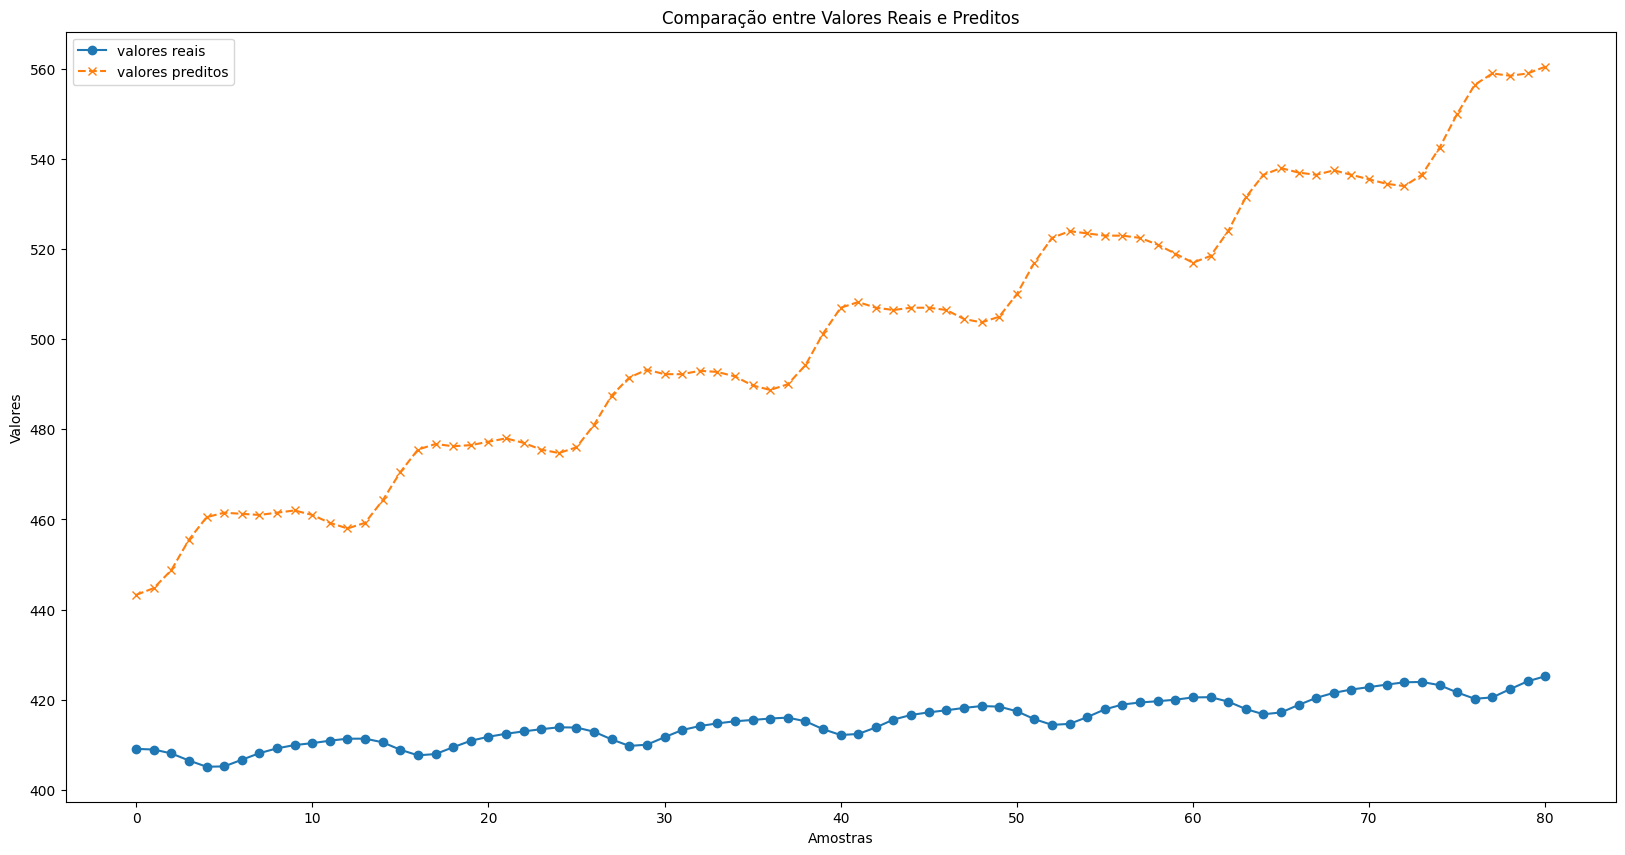

In [387]:
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Evitar divisão por zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calcular métricas
# f1 = f1_score(dataParaComparativo, dataPredicaoTratada)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
accuracy = 100 - mape

# print(f"  🔹 R² (Coeficiente de Determinação): {f1:.2f}") #Função criada para teste, entretanto não foi possivel aplicar aqui
print(f"  🔹 R² (Coeficiente de Determinação): ------------ {r2:.4f}")
print(f"  🔹 RMSE (Raiz Quadrada do Erro Quadrático Médio): {rmse:.4f}")
print(f"  🔹 MAE (Erro Absoluto Médio): ------------------- {mae:.4f}")
print(f"  🔹 MAPE (Erro Percentual Absoluto): ------------- {mape:.4f}%")
print(f"  🔹 Acurácia: ------------------------------------ {accuracy:.4f}%")

print(f'  🔹 Neurons: ----- {neurons}')
print(f'  🔹 Epochs: ------ {epochs}')
print(f'  🔹 Batch Size: -- {batch_size}')
print(f'  🔹 Hidden Layers: {hidden_layers}')

aux.plotLine(
    y_test,
    df_label="valores reais",
    df_marker='o',
    compare=y_pred,
    compare_label="valores preditos",
    compare_marker='x',
    xlabel="Amostras",
    ylabel="Valores",
    title="Comparação entre Valores Reais e Preditos",
    )